# ffp

> A module to model and calculate the properties of Free Floating Planets (FFPs), such as density, mass, distance, and velocity distribution.

In [1]:
#| default_exp ffp

In [1]:
#| hide
from nbdev.showdoc import *

In [2]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *
from LensCalcPy.lens import *
from LensCalcPy.galaxy import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import quad, nquad, dblquad, tplquad
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import minimize_scalar
import pickle
import functools
from pathos.multiprocessing import ProcessingPool as Pool

import functools

from fastcore.test import *
from tqdm import tqdm


In [3]:
%load_ext autoreload
%autoreload 2

In [112]:
#| export 

class Ffp(Lens):
    """A class to represent a PBH population"""

    def __init__(self,
                p: float = 1, # Mass function power law index
                m_min: float = 1e-15, # Minimum mass in Msun
                m_max: float = 1e-3, # Maximum mass in Msun
                mw_model: MilkyWayModel = None,
                m31_model: M31Model = None, 
                l = None, # Galactic longitude
                b = None, # Galactic latitude
                u_t = 1, #threshold impact parameter in point-source limit
                ds = 770,
                ):
        """
        Initialize the PBH population
        """

        self.ut_interp = ut_func_new

        self.p = p
        #Define range of power law we want to consider
        self.m_min = m_min
        self.m_max = m_max
        self.M_norm = 1 #solar mass
        # self.Z = self.pl_norm(self.p)
        self.Z = self.pl_norm_new()
        self.Zprime = self.dN_dM_norm()

        # Instantiate or use existing MilkyWayModel and M31Model
        self.mw_model = mw_model or MilkyWayModel(mw_parameters)
        self.m31_model = m31_model or M31Model(m31_parameters)

        if l is None:
            raise ValueError("Galactic longitude must be specified")
        if b is None:
            raise ValueError("Galactic latitude must be specified")
        self.l = l
        self.b = b
        self.u_t = u_t
        self.ds = ds

    
    def __str__(self) -> str:
        return f"FFP with power law dN / dlogM ~ m^-{self.p}"
    __repr__ = __str__

    def dN_dM(self, M, M_norm, p):
        return (M/M_norm)**(-p-1) / M_norm
    
    def dN_dM_wrapper(self, M):
        return self.dN_dM(M, self.M_norm, self.p)

    def dN_dM_norm(self):
        return 1/abs(nquad(self.dN_dM_wrapper,[[self.m_min, self.m_max]], opts={'points': [self.m_min, self.m_min*1e3, self.m_min*1e6, self.m_max]})[0])
    
    def f_m(self, M):
        return self.dN_dM_wrapper(M)*self.Zprime

    def dN_dlogM(self, A, log10M, M_norm, p):
        M = 10**log10M
        return A * (M/self.M_norm)**-p
    
    def dN_dlogM_wrapper(self, M):
        return self.dN_dlogM(1, M, self.M_norm, self.p)
    
    def pl_norm_new(self):
        return 1/abs(nquad(self.dN_dlogM_wrapper,[[np.log10(self.m_min), np.log10(self.m_max)]], opts={'points': [np.log10(self.m_min), np.log10(self.m_min*1e3), np.log10(self.m_max*1e3)]})[0])

    def mass_func(self, log10m):
        #M_norm = 1 solar mass for now. This is dN/dlogM
        m = 10**log10m
        return self.Z * (m/1)**-self.p
    
    def pl_norm(self, p):
        N_ffp = 1 # Number of FFPs per star
        return N_ffp/abs(nquad(self.mass_func,[[self.m_min, self.m_max]], opts={'points': [self.m_min, self.m_min*1e3]})[0])

    # def differential_rate_integrand(self, umin, d, mf, t, dist_func, density_func, v_disp_func, finite=False):
    def differential_rate_integrand(self, umin, d, t, mf, dist_func, density_func, v_disp_func, finite=False):
        r = dist_func(d, self.l, self.b)
        # ut = self.umin_upper_bound(d, mf) if (self.ut_interp and finite) else self.u_t
        ut = self.umin_upper_bound(d, mf) if finite else self.u_t
        if ut <= umin:
            return 0
        v_rad = velocity_radial(d, mf, umin, t * htosec, ut)  
        v_disp = v_disp_func(r)
        return 2 * (1 / (ut**2 - umin**2)**0.5 *
                        #For FFP number density, use stellar density for 1 solar mass stars
                density_func(d) / (1 * v_disp**2) *  
                v_rad**4 * (htosec / kpctokm)**2 *
                np.exp(-(v_rad**2 / v_disp**2)) *
                1)


    def differential_rate(self, t, integrand_func, finite=False):
        #rewrite using tplquad?
        num = 40  # number of discretization points, empirically, result levels off for >~ 40
        mf_values = np.linspace(np.log10(self.m_min), np.log10(self.m_max), num=num)

        result = 0
        for i in range(num):
            mf = mf_values[i]
            if i == 0:  # for the first point
                dm = mf_values[i+1] - mf_values[i]
            elif i < num - 1:  # for middle points
                dm = ((mf_values[i+1] - mf_values[i]) + (mf_values[i] - mf_values[i-1])) / 2
            else:  # for the last point
                dm = mf_values[i] - mf_values[i-1]
            if finite:
                single_result, error = dblquad(integrand_func, 
                                            # 0, 10, 
                                            0, self.d_upper_bound(10**mf),
                                            lambda d: 0, 
                                            lambda d: self.umin_upper_bound(d, 10**mf),
                                            # args=(mf, t),
                                            args=(10**mf, t),
                                            # epsabs=0,
                                            # epsrel=1e-1,
                                            )
            else:
                single_result, error = dblquad(integrand_func,
                                               #Without finite size effects, integral blows up at M31 center
                                            0, 10,
                                            lambda d: 0, 
                                            lambda d: self.u_t,
                                            args=(10**mf, t),
                                            # epsabs=0,
                                            # epsrel=1e-2,
                                            )
            # if single_result != 0 and error/abs(single_result) >=1:
                # print("Warning: error in differential rate integration is large: {}".format(error/abs(single_result)))
            
            result += single_result * ((10**mf/1) ** -self.p) * dm # multiply by mass function and by dlogm. This is for dN/dlogM

        result *= self.Z  # normalization
        return result

    
    def differential_rate_monochromatic(self, t, integrand_func, finite=False, m=1e-10):
        if finite:
            result, error = dblquad(integrand_func, 
                                        0, self.d_upper_bound(m), 
                                        lambda d: 0, 
                                        lambda d: self.umin_upper_bound(d, m),
                                        # args=(m, t),
                                        args=(m, t, {'points':[0, self.ds]}),
                                        epsabs=0,
                                        epsrel=1e-1,
                                        )
            
        else:
            result, error = dblquad(integrand_func,
                                            #Without finite size effects, integral blows up at M31 center
                                        0, self.ds*0.99,
                                        lambda d: 0, 
                                        lambda d: self.u_t,
                                        args=(m, t),
                                        )
        return result

        
    def differential_rate_integrand_mw(self, umin, d, mf, t, finite=True, vel_func=None):
        if vel_func is None:
            vel_func = self.mw_model.velocity_dispersion_stars
        return self.differential_rate_integrand(umin, d, t, mf, self.mw_model.dist_center, self.mw_model.density_stars, vel_func, finite=finite)

    def differential_rate_mw(self, t, finite=True, v_disp=None):
        if v_disp:
            vel_func = lambda r: v_disp
            f = functools.partial(self.differential_rate_integrand_mw, vel_func=vel_func, finite=finite)
            return self.differential_rate(t, f, finite=finite)
        # return self.differential_rate(t, self.differential_rate_integrand_mw, finite=finite)
        f = functools.partial(self.differential_rate_integrand_mw, finite=finite)
        return self.differential_rate(t, f, finite=finite)

    def differential_rate_mw_monochromatic(self, t, finite=False, m=1e-10):
        return self.differential_rate_monochromatic(t, self.differential_rate_integrand_mw, finite=finite, m=m)

    def differential_rate_integrand_m31(self, umin, d, mf, t, finite=True, vel_func=None):
        if vel_func is None:
            vel_func = self.m31_model.velocity_dispersion_stars
        return self.differential_rate_integrand(umin, d, t, mf, self.m31_model.dist_center, self.m31_model.density_stars, vel_func, finite=finite)

    def differential_rate_m31(self, t, finite=False, v_disp=None):
        if v_disp:
            vel_func = lambda r: v_disp
            f = functools.partial(self.differential_rate_integrand_m31, vel_func=vel_func, finite=finite)
            return self.differential_rate(t, f, finite=finite)
        f = functools.partial(self.differential_rate_integrand_m31, finite=finite)
        return self.differential_rate(t, self.differential_rate_integrand_m31, finite=finite)

    def differential_rate_m31_monochromatic(self, t, finite=False, m=1e-10):
        return self.differential_rate_monochromatic(t, self.differential_rate_integrand_m31, finite=finite, m=m)

    def umin_upper_bound(self, d, m):
        rho = rho_func(m, d, self.ds)
        return self.ut_interp(rho, magnification(self.u_t))

    def d_upper_bound(self, m):
        #Determine upper limit for d otherwise for low masses, the contribution which only comes from d << 1 gets missed
        d_arr = np.logspace(-3, np.log10(self.ds*0.99), 100)
        for d in d_arr:
            if self.umin_upper_bound(d, m) == 0:
                return d
        return self.ds
    
    def sticking_point(self,m):
        #Determine where u_t is maximized. This speeds up the integral in m31
        result = minimize_scalar(lambda d:-self.umin_upper_bound(d, m), bounds=(0, self.ds), method='bounded')
        if result.success:
            return result.x[0] if isinstance(result.x, (list, np.ndarray)) else result.x
        else:
            return self.ds
    
    def differential_rate_total(self, t, finite=False):
        return self.differential_rate_mw(t, finite=finite) + self.differential_rate_m31(t, finite=finite)
 
    def compute_differential_rate(self, ts, finite=False):
        return [self.differential_rate_total(t, finite=finite) for t in ts]

    def differential_rate_integrand_mw_mass(self, umin, d, t, mf, finite=True, vel_func=None):
        if vel_func is None:
            vel_func = self.mw_model.velocity_dispersion_stars     
        return self.differential_rate_integrand(umin, d, t, mf, self.mw_model.dist_center, self.mw_model.density_stars, vel_func, finite=finite)
    
    def differential_rate_integrand_m31_mass(self, umin, d, t, mf, finite=True, vel_func=None):
        if vel_func is None:
            vel_func = self.m31_model.velocity_dispersion_stars
        return self.differential_rate_integrand(umin, d, t, mf, self.m31_model.dist_center, self.m31_model.density_stars, vel_func, finite=finite)
    
    def differential_rate_mass(self, m, integrand_func, finite=True, tcad=0.07, tobs=3, d_lower = 0, d_upper=np.inf, epsabs = 1.49e-08, epsrel = 1.49e-08, efficiency=None, monochromatic=False):        
        
        if efficiency is None:
            def efficiency(t):
                return 1
            
        point = self.sticking_point(m)

        def integrand(t, d, m, finite):
            if finite:
                u_bounds = [0, self.umin_upper_bound(d, m)]
            else:
                u_bounds = [0, self.u_t]
            u_result, _ = nquad(integrand_func, [u_bounds], args=(d, t, m))
            return u_result * efficiency(t)

        bounds_t = [tcad, tobs]

        if finite:
            bounds_d = [d_lower, min(self.d_upper_bound(m), d_upper)]
        else:
            bounds_d = [d_lower, min(self.ds, d_upper)]

        opts = {"epsabs": epsabs, "epsrel": epsrel, "points":[point, self.ds]}

        result, error = nquad(integrand, [bounds_t, bounds_d], args=(m, finite), opts=opts)

        # if result > 0 and error/result > 0.1: #redo with higher precision 
        #     print('Error greater than 10%, recalculating integral with higher precision')
        #     opts = {"epsabs": 0, "epsrel": 1e-1, "points":[point, self.ds]}
        #     result, error = nquad(integrand, [bounds_t, bounds_d], args=(m, finite), opts=opts)

        if monochromatic:
            return result
        return result*self.f_m(m)


    
    def differential_rate_mw_mass(self, m, finite=True, v_disp=None, tcad=0.07, tobs=3, d_lower=0, d_upper=np.inf, epsabs = 1.49e-08, epsrel = 1.49e-08, efficiency=None, monochromatic=False):
        if v_disp:
            vel_func = lambda r: v_disp
            f = functools.partial(self.differential_rate_integrand_mw_mass, vel_func=vel_func, finite=finite)
        else:
            f = functools.partial(self.differential_rate_integrand_mw_mass, finite=finite)
        return self.differential_rate_mass(m, f, finite=finite, tcad=tcad, tobs=tobs, d_lower=d_lower, d_upper=d_upper, epsabs = epsabs, epsrel = epsrel, efficiency=efficiency, monochromatic=monochromatic)
    
    def differential_rate_m31_mass(self, m, finite=True, v_disp=None, tcad=0.07, tobs=3, d_lower=0, d_upper=np.inf, epsabs = 1.49e-08, epsrel = 1.49e-08, efficiency=None, monochromatic=False):
        if v_disp:
            vel_func = lambda r: v_disp
            f = functools.partial(self.differential_rate_integrand_m31_mass, vel_func=vel_func, finite=finite)
        else:
            f = functools.partial(self.differential_rate_integrand_m31_mass, finite=finite)
        return self.differential_rate_mass(m, f, finite=finite, tcad=tcad, tobs=tobs, d_lower = self.ds*0.5, d_upper=d_upper, epsabs = epsabs, epsrel = epsrel, efficiency=efficiency, monochromatic=monochromatic)


In [14]:
p = 1.0
# p = 0.9
f = Ffp(p, l = l, b = b, u_t = 1)
# f = Ffp(0.92, l = 359.9392, b = -1.6400, u_t = 1, ds=8.5)

In [16]:
ogle_df = pd.read_csv('../examples/ogle_sensitivity.csv', header=None, names=['log_10(t/d)', 'efficiency'])
ogle_efficiency_interp = interp1d(ogle_df['log_10(t/d)'], ogle_df['efficiency'])
def ogle_efficiency(t):
    '''
    Takes in crossing time in hours and returns the efficiency of OGLE
    '''
    t_day = t/24
    log10_t_day = np.log10(t_day)
    if log10_t_day <= np.min(ogle_df['log_10(t/d)']):
        return ogle_df['efficiency'][0]
    if log10_t_day >= np.max(ogle_df['log_10(t/d)']):
        return ogle_df['efficiency'][len(ogle_df)-1]
    return(ogle_efficiency_interp(log10_t_day))

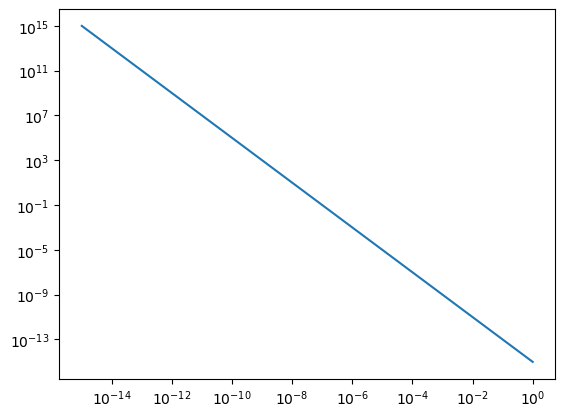

In [97]:
# m_arr = np.logspace(-15, -3, 30)
m_arr = np.logspace(-15, 0, 30)

m_pdf = np.array([f.f_m(M) for M in m_arr])
plt.loglog(m_arr,m_pdf)
plt.show()

In [ ]:
def differential_rate_mw_mass_ogle(m, tcad = 2.4, tobs= 240, finite=True, v_disp=90):
    return f.differential_rate_mw_mass(m, tcad=tcad, tobs=tobs, finite=finite, efficiency=ogle_efficiency, v_disp=v_disp, epsabs=0, epsrel=1e-1)

with Pool() as pool:
    func = functools.partial(differential_rate_mw_mass_ogle, finite=True)
    d_gamma_d_ms_ogle_e  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms_ogle_e = np.array(d_gamma_d_ms_ogle_e)

with Pool() as pool:
    func = functools.partial(differential_rate_mw_mass_ogle, finite=False)
    d_gamma_d_ms_ogle_e_point  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms_ogle_e_point = np.array(d_gamma_d_ms_ogle_e_point)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [03:20<00:00,  6.68s/it]


In [ ]:
ogle_diff_rate_interp_log = interp1d(np.log10(m_arr), np.log10(d_gamma_d_ms_ogle_e))
def ogle_diff_rate_interp(m):
    return 10**ogle_diff_rate_interp_log(np.log10(m))

ogle_rates = np.array([quad(ogle_diff_rate_interp, m_arr[i],m_arr[i+1])[0] for i in range(len(m_arr)-1)])
mean_values = (m_arr[:-1] + m_arr[1:]) / 2

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_9906/3274081622.py:1: RuntimeWarning: divide by zero encountered in log10
  ogle_diff_rate_interp_log = interp1d(np.log10(m_arr), np.log10(d_gamma_d_ms_ogle_e))


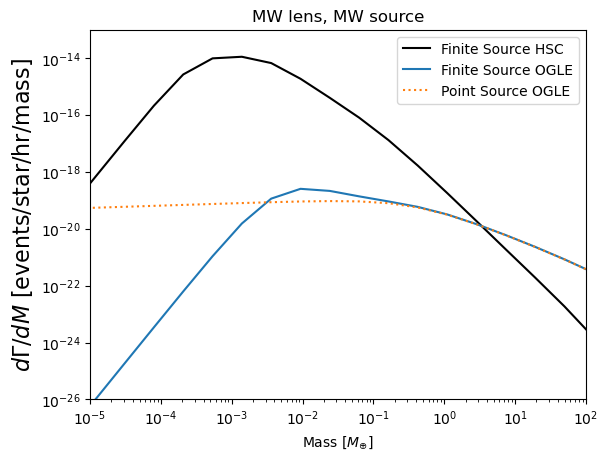

In [28]:
plt.loglog(m_arr/3e-6, d_gamma_d_ms, label='Finite Source HSC', color='k')
plt.loglog(m_arr/3e-6, d_gamma_d_ms_ogle_e, label='Finite Source OGLE')
plt.loglog(m_arr/3e-6, d_gamma_d_ms_ogle_e_point, label='Point Source OGLE', ls=':', )

plt.xlabel("Mass [$M_{\oplus}$]")
plt.ylabel(r"$d\Gamma/dM$ [events/star/hr/mass]", fontsize=16)
plt.title('MW lens, MW source')
plt.xlim(1e-5, 1e2)
plt.ylim(1e-26, 1e-13)
plt.legend()
plt.show()

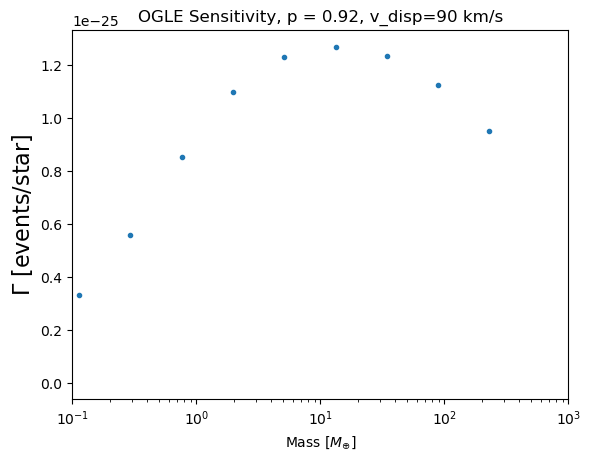

In [ ]:
#OGLE RATE FOR MW SOURCE, full LOS, longer Obs, p = 0.92, v_disp = 90
plt.plot(mean_values/3e-6,ogle_rates, '.')
plt.xlabel("Mass [$M_{\oplus}$]")
plt.ylabel(r"$\Gamma$ [events/star]", fontsize=16)
plt.xscale('log')
plt.xlim(1e-1, 1e3)
plt.title("OGLE Sensitivity, p = 0.92, v_disp=90 km/s")
plt.show()


/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_14386/4167911864.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vals = np.array([f.differential_rate_integrand_mw_mass(umin, d, t, m) for d in d_tests])*f.f_m(m)
/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_14386/4167911864.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vals2 = np.array([f.differential_rate_integrand_mw_mass(umin, d, t, 10*m) for d in d_tests])*f.f_m(10*m)
/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_14386/4167911864.py:7: VisibleDeprecat

Text(0, 0.5, 'integrand')

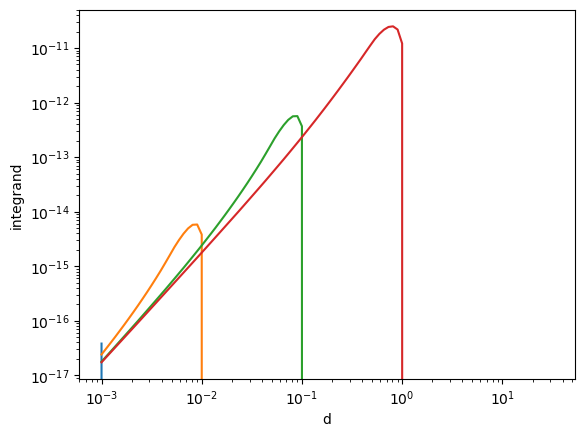

In [111]:
umin=0.5
t = .1
m = 1e-15
d_tests = np.logspace(-3, 1.5, 100)
vals = np.array([f.differential_rate_integrand_mw_mass(umin, d, t, m) for d in d_tests])*f.f_m(m)
vals2 = np.array([f.differential_rate_integrand_mw_mass(umin, d, t, 10*m) for d in d_tests])*f.f_m(10*m)
vals3 = np.array([f.differential_rate_integrand_mw_mass(umin, d, t, 100*m) for d in d_tests])*f.f_m(100*m)
vals4 = np.array([f.differential_rate_integrand_mw_mass(umin, d, t, 1000*m) for d in d_tests])*f.f_m(1000*m)

plt.loglog(d_tests, vals)
plt.loglog(d_tests, vals2)
plt.loglog(d_tests, vals3)
plt.loglog(d_tests, vals4)
plt.xlabel('d')
plt.ylabel('integrand')


In [101]:
def differential_rate_mw_mass(m, tcad = 0.07, tobs= 3, finite=True, d_upper=2):
    return f.differential_rate_mw_mass(m, tcad=tcad, tobs=tobs, finite=finite, d_upper=d_upper)
    # return f.differential_rate_mw_mass(m, tcad=tcad, tobs=tobs, finite=finite, d_upper=d_upper, epsabs=0, epsrel=1e-1)

def differential_rate_m31_mass(m, tcad = 0.07, tobs= 3, finite=True, d_lower=f.ds/2):
    if finite:
        #Need higher precision for finite case
        return f.differential_rate_m31_mass(m, tcad=tcad, tobs=tobs, finite=finite, d_lower=d_lower, epsabs=0, epsrel=1e-1)
    else:
        return f.differential_rate_m31_mass(m, tcad=tcad, tobs=tobs, finite=finite, d_lower=d_lower)


In [102]:
with Pool() as pool:
    func = functools.partial(differential_rate_mw_mass, tcad=0.07, tobs=3, finite=True)
    d_gamma_d_ms  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms = np.array(d_gamma_d_ms)

with Pool() as pool:
    func = functools.partial(differential_rate_mw_mass, tcad=0.07, tobs=3, finite=False)
    d_gamma_d_ms_point  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms_point = np.array(d_gamma_d_ms_point)

with Pool() as pool:
    func = functools.partial(differential_rate_mw_mass, tcad=1, tobs=3, finite=True)
    d_gamma_d_ms_lowcad  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms_lowcad = np.array(d_gamma_d_ms_lowcad)

with Pool() as pool:
    func = functools.partial(differential_rate_mw_mass, tcad=1, tobs=3, finite=False)
    d_gamma_d_ms_point_lowcad  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms_point_lowcad = np.array(d_gamma_d_ms_point_lowcad)

100%|██████████| 30/30 [00:05<00:00,  5.72it/s]


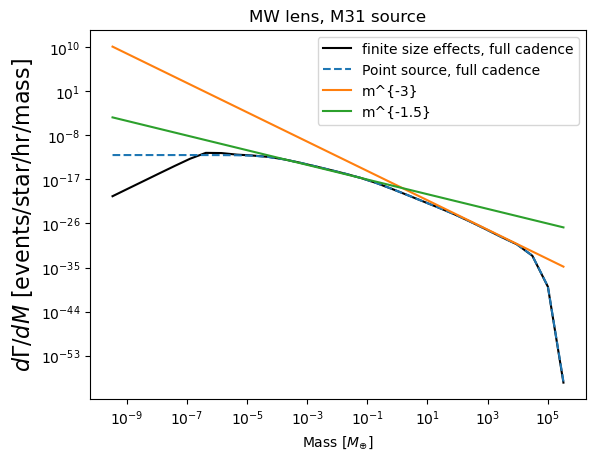

In [108]:
plt.loglog(m_arr/3e-6, d_gamma_d_ms, label='finite size effects, full cadence', color='k')
plt.loglog(m_arr/3e-6, d_gamma_d_ms_point, label='Point source, full cadence', ls='--')
# plt.loglog(m_arr/3e-6, d_gamma_d_ms_lowcad, label='finite size effects, low cadence', ls=':')
# plt.loglog(m_arr/3e-6, d_gamma_d_ms_point_lowcad, label='Point source, low cadence', ls='--', )

# plt.loglog(m_arr/3e-6, 1.5e-33*m_arr**(-2.5), label="m^{-2.5}")
plt.loglog(m_arr/3e-6, 1.5e-35*m_arr**(-3), label="m^{-3}")

plt.loglog(m_arr/3e-6, 1.6e-27*m_arr**(-1.5), label="m^{-1.5}")
# plt.ylim(1e-24, 1e-8)

plt.xlabel("Mass [$M_{\oplus}$]")
plt.ylabel(r"$d\Gamma/dM$ [events/star/hr/mass]", fontsize=16)
plt.title('MW lens, M31 source')
plt.legend()
plt.show()

In [19]:
with Pool() as pool:
    func = functools.partial(differential_rate_m31_mass, tcad=0.07, tobs=3, finite=True)
    d_gamma_d_ms_m31  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms_m31 = np.array(d_gamma_d_ms_m31)

with Pool() as pool:
    func = functools.partial(differential_rate_m31_mass, tcad=0.07, tobs=3, finite=False)
    d_gamma_d_ms_point_m31  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms_point_m31 = np.array(d_gamma_d_ms_point_m31)

with Pool() as pool:
    func = functools.partial(differential_rate_m31_mass, tcad=1, tobs=3, finite=True)
    d_gamma_d_ms_lowcad_m31  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms_lowcad_m31 = np.array(d_gamma_d_ms_lowcad_m31)

with Pool() as pool:
    func = functools.partial(differential_rate_m31_mass, tcad=1, tobs=3, finite=False)
    d_gamma_d_ms_point_lowcad_m31  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms_point_lowcad_m31 = np.array(d_gamma_d_ms_point_lowcad_m31)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:01<00:00, 15.71it/s]


/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


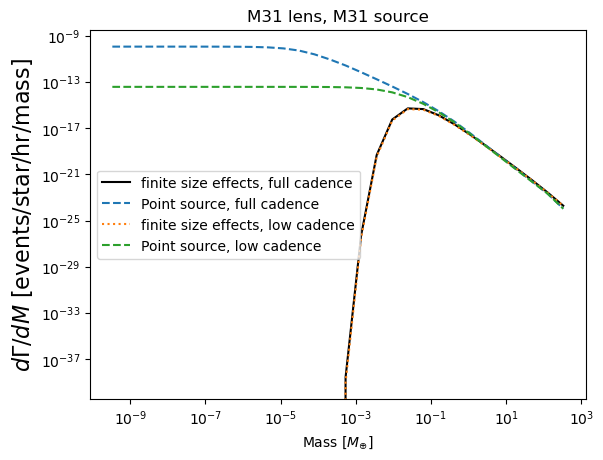

In [20]:
plt.loglog(m_arr/3e-6, d_gamma_d_ms_m31, label='finite size effects, full cadence', color='k')
plt.loglog(m_arr/3e-6, d_gamma_d_ms_point_m31, label='Point source, full cadence', ls='--')
plt.loglog(m_arr/3e-6, d_gamma_d_ms_lowcad_m31, label='finite size effects, low cadence', ls=':')
plt.loglog(m_arr/3e-6, d_gamma_d_ms_point_lowcad_m31, label='Point source, low cadence', ls='--', )

plt.xlabel("Mass [$M_{\oplus}$]")
plt.ylabel(r"$d\Gamma/dM$ [events/star/hr/mass]", fontsize=16)
plt.title('M31 lens, M31 source')
plt.legend()
plt.show()

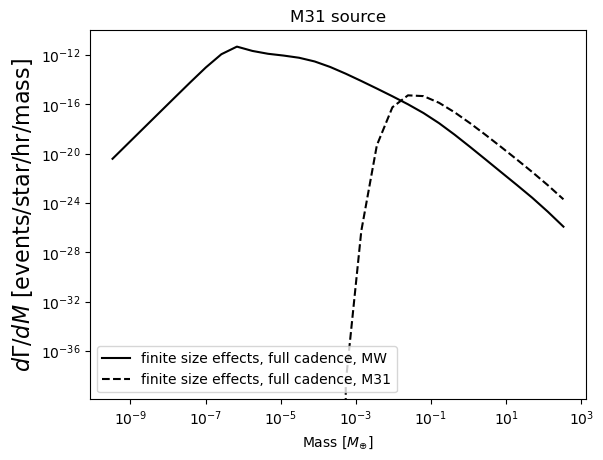

In [21]:
plt.loglog(m_arr/3e-6, d_gamma_d_ms, label='finite size effects, full cadence, MW', color='k')
plt.loglog(m_arr/3e-6, d_gamma_d_ms_m31, label='finite size effects, full cadence, M31', color='k', ls='--')
plt.xlabel("Mass [$M_{\oplus}$]")
plt.ylabel(r"$d\Gamma/dM$ [events/star/hr/mass]", fontsize=16)
plt.title('M31 source')
plt.legend()
plt.show()

In [22]:
hsc_diff_rate_mw_interp_log = interp1d(np.log10(m_arr), np.log10(d_gamma_d_ms))
def diff_rates_m_mw_interp(m):
    return 10**hsc_diff_rate_mw_interp_log(np.log10(m))

hsc_rates_mw = np.array([quad(diff_rates_m_mw_interp, m_arr[i],m_arr[i+1])[0] for i in range(len(m_arr)-1)])


In [23]:
hsc_diff_rate_m31_interp_log = interp1d(np.log10(m_arr), np.log10(d_gamma_d_ms_m31))
def diff_rates_m_m31_interp(m):
    return 10**hsc_diff_rate_m31_interp_log(np.log10(m))

hsc_rates_m31 = np.array([quad(diff_rates_m_m31_interp, m_arr[i],m_arr[i+1])[0] for i in range(len(m_arr)-1)])

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_9178/3565655918.py:1: RuntimeWarning: divide by zero encountered in log10
  hsc_diff_rate_m31_interp_log = interp1d(np.log10(m_arr), np.log10(d_gamma_d_ms_m31))


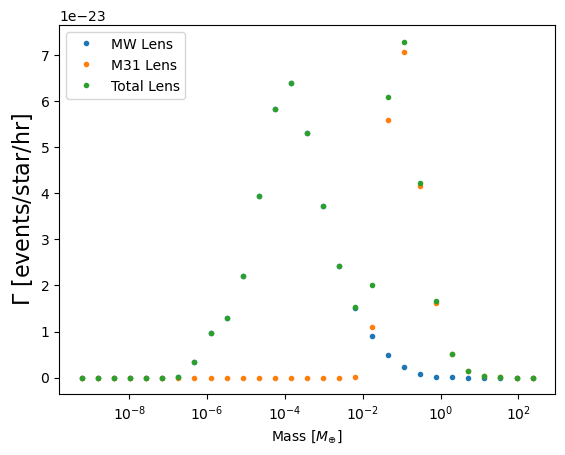

In [24]:
#HSC Rate MW Lens
mean_values = (m_arr[:-1] + m_arr[1:]) / 2
plt.plot(mean_values/3e-6,hsc_rates_mw, '.', label='MW Lens')
plt.plot(mean_values/3e-6,hsc_rates_m31, '.', label='M31 Lens')
plt.plot(mean_values/3e-6,hsc_rates_m31+hsc_rates_mw, '.', label='Total Lens')

plt.xscale('log')
plt.xlabel("Mass [$M_{\oplus}$]")
plt.ylabel(r"$\Gamma$ [events/star/hr]", fontsize=16)
# plt.title('MW lens w finite-source effects, M31 source')
plt.legend(loc='upper left')
plt.show()

In [29]:
quad(diff_rates_m_m31_interp, m_arr[0],m_arr[-1], epsabs=0, epsrel=1e-1)[0]

1.9977551180945848e-22

In [30]:
quad(diff_rates_m_mw_interp, m_arr[0],m_arr[-1], epsabs=0, epsrel=1e-1)[0] 

3.580157260576037e-22

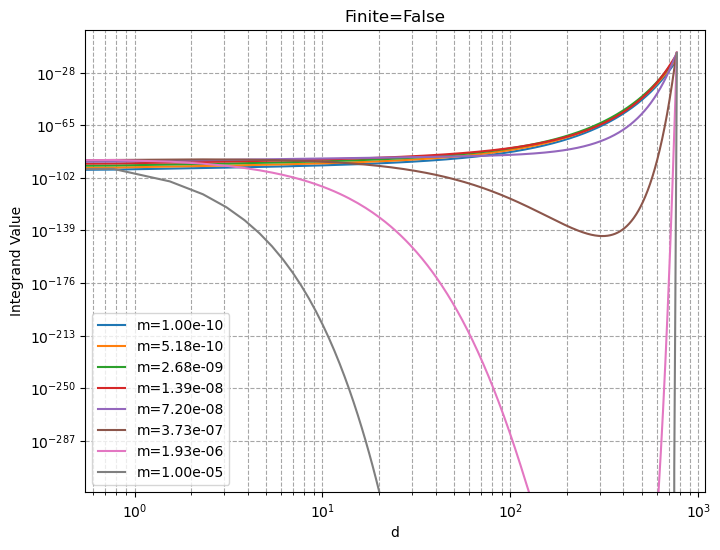

In [35]:
m_vals = np.logspace(-10, -5, 8)
d_arr = np.linspace(0, ds*0.99999, 1000)
t = 1

integrand_vals = np.array([[f.differential_rate_integrand_m31(0.9, d, m, t, finite=False) for d in d_arr] for m in m_vals])
# velocity_vals = np.array([[velocity_radial(d, m, 0.5, t * htosec, 1) for d in d_arr] for m in m_vals])

plt.figure(figsize=(8, 6))
for i, u in enumerate(m_vals):
    plt.loglog(d_arr, integrand_vals[i], label=f'm={u:.2e}')
    # plt.loglog(d_arr, velocity_vals[i], label=f'm={u:.2e}')

plt.xlabel('d')
plt.ylabel('Integrand Value')
# plt.ylabel('Velocity Value')

plt.title('Finite=False')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.65')
plt.show()


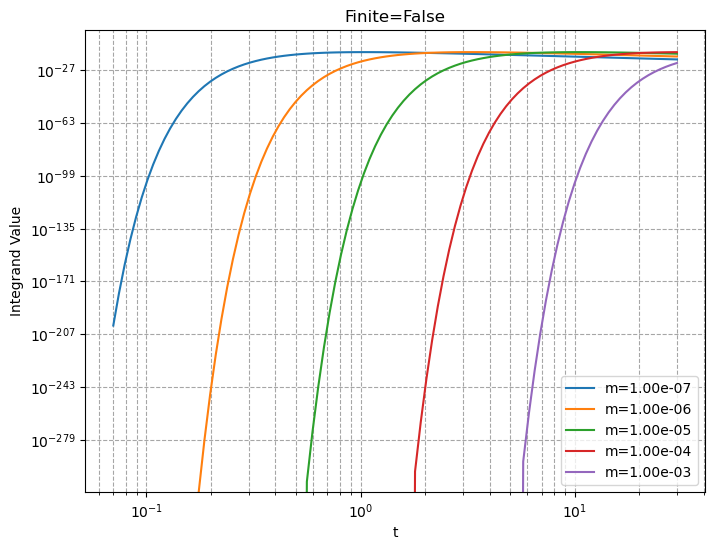

In [56]:
m_vals = np.logspace(-7, -3, 5)
# d_arr = np.linspace(0, ds*0.99999, 1000)
t_arr = np.logspace(np.log10(0.07), np.log10(30), 100)
d = 0.99*f.ds

integrand_vals = np.array([[f.differential_rate_integrand_m31(0.9, d, m, t, finite=False) for t in t_arr] for m in m_vals])
# velocity_vals = np.array([[velocity_radial(d, m, 0.5, t * htosec, 1) for d in d_arr] for m in m_vals])

plt.figure(figsize=(8, 6))
for i, u in enumerate(m_vals):
    plt.loglog(t_arr, integrand_vals[i], label=f'm={u:.2e}')
    # plt.loglog(d_arr, velocity_vals[i], label=f'm={u:.2e}')

plt.xlabel('t')
plt.ylabel('Integrand Value')
# plt.ylabel('Velocity Value')

plt.title('Finite=False')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.65')
plt.show()


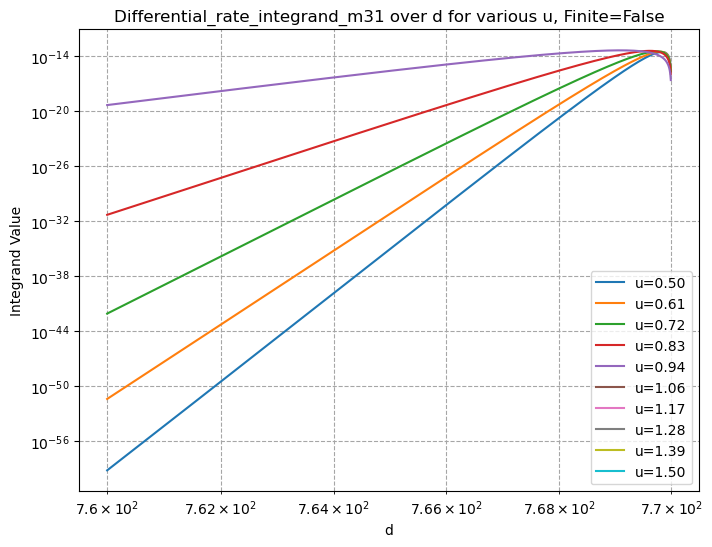

In [23]:
u_vals = np.linspace(0.5, 1.5, 10)
d_arr = np.linspace(760, ds*0.99999, 1000)

integrand_vals = np.array([[f.differential_rate_integrand_m31(u, d, 1e-6, t, finite=False) for d in d_arr] for u in u_vals])

plt.figure(figsize=(8, 6))
for i, u in enumerate(u_vals):
    plt.loglog(d_arr, integrand_vals[i], label=f'u={u:.2f}')
plt.xlabel('d')
plt.ylabel('Integrand Value')
plt.title('Differential_rate_integrand_m31 over d for various u, Finite=False')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.65')
plt.show()


/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_79769/4105421970.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  integrand_vals = np.array([[f.differential_rate_integrand_m31(u, d, 1e-6, t, finite=True) for d in d_arr] for u in u_vals])


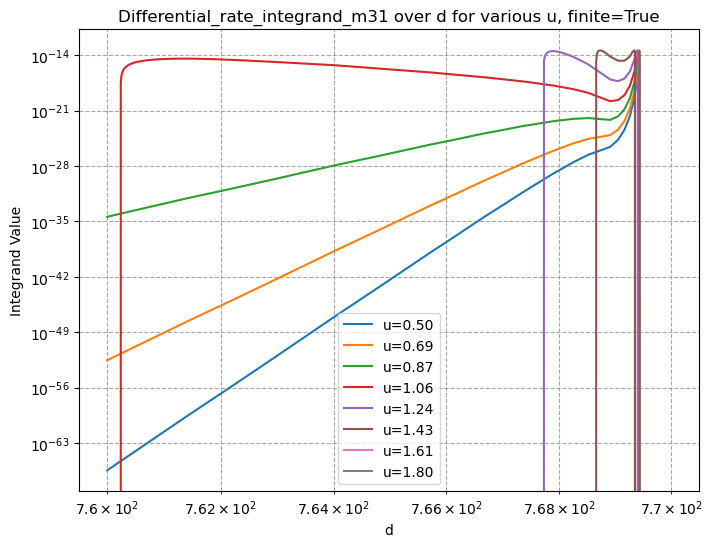

In [24]:
# d_arr = np.logspace(-2, np.log10(ds), 100000)
# integrand_vals = np.array([f.differential_rate_integrand_m31(.9, d, 1e-7, t) for d in d_arr])
# # density_vals = np.array([f.m31_model.density_stars(d) for d in d_arr])

# plt.loglog(d_arr, integrand_vals)
# # plt.loglog(d_arr, density_vals)

u_vals = np.linspace(0.5, 1.8, 8)
# d_arr = np.logspace(np.log10(750), np.log10(ds), 1000)
d_arr = np.linspace(760, ds*0.99999, 1000)

integrand_vals = np.array([[f.differential_rate_integrand_m31(u, d, 1e-6, t, finite=True) for d in d_arr] for u in u_vals])

plt.figure(figsize=(8, 6))
for i, u in enumerate(u_vals):
    plt.loglog(d_arr, integrand_vals[i], label=f'u={u:.2f}')
plt.xlabel('d')
plt.ylabel('Integrand Value')
plt.title('Differential_rate_integrand_m31 over d for various u, finite=True')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.65')
plt.show()


In [21]:
ts = np.logspace(-2, 1, num=10)

diff_rates_finite_mw = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw.append(f.differential_rate_mw(t, finite=True))

diff_rates_finite_m31 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31.append(f.differential_rate_m31(t, finite=True))

Computing differential rates for MW (finite=True): 100%|██████████| 10/10 [07:35<00:00, 45.54s/it]
Computing differential rates for M31 (finite=True):  20%|██        | 2/10 [00:00<00:02,  3.35it/s]/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
Computing differential rates for M31 (finite=True): 100%|██████████| 10/10 [02:27<00:00, 14.77s/it]


In [189]:
diff_rates_finite_mw_60 = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw_60.append(f.differential_rate_mw(t, finite=True, v_disp=60))

diff_rates_finite_m31_120 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31_120.append(f.differential_rate_m31(t, finite=True, v_disp=120))

Computing differential rates for MW (finite=True): 100%|██████████| 20/20 [01:05<00:00,  3.29s/it]
Computing differential rates for M31 (finite=True): 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


In [190]:
diff_rates_finite_mw_15 = []
for t in tqdm(ts, desc='Computing differential rates for MW (finite=True)'):
    diff_rates_finite_mw_15.append(f.differential_rate_mw(t, finite=True, v_disp=15))

diff_rates_finite_m31_30 = []
for t in tqdm(ts, desc='Computing differential rates for M31 (finite=True)'):
    diff_rates_finite_m31_30.append(f.differential_rate_m31(t, finite=True, v_disp=30))

Computing differential rates for MW (finite=True): 100%|██████████| 20/20 [00:55<00:00,  2.77s/it]
Computing differential rates for M31 (finite=True): 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


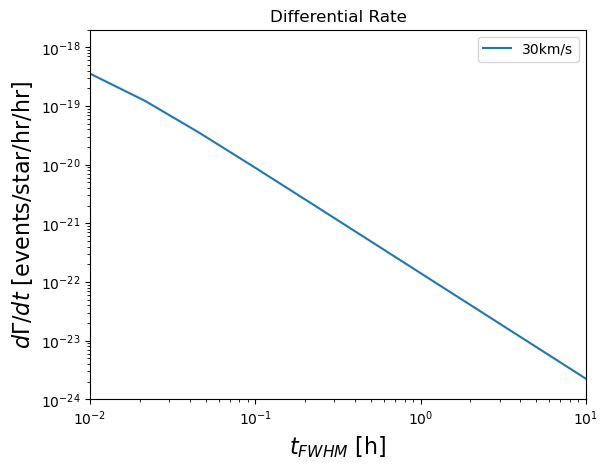

In [24]:
plt.loglog(np.array(ts), np.array(diff_rates_finite_mw), label="30km/s", linestyle='-')

plt.xlabel(r"$t_{FWHM}$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.title('Differential Rate')
plt.xlim(min(ts), max(ts))
plt.ylim(1e-24,2e-18)
plt.legend()
plt.show()

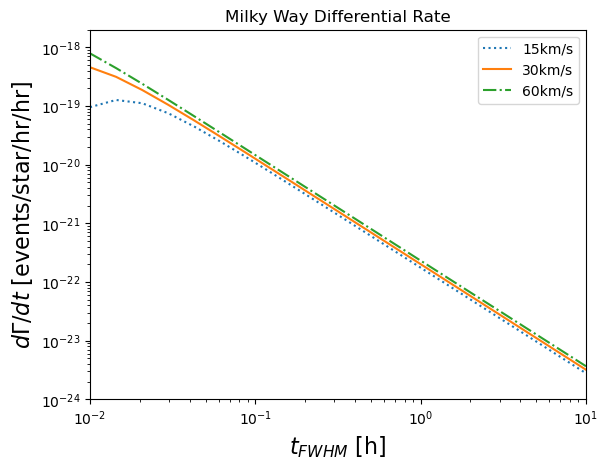

In [202]:
plt.loglog(np.array(ts), np.array(diff_rates_finite_mw_15), label="15km/s", linestyle=':')
plt.loglog(np.array(ts), np.array(diff_rates_finite_mw), label="30km/s", linestyle='-')
plt.loglog(np.array(ts), np.array(diff_rates_finite_mw_60), label="60km/s", linestyle='-.')

plt.xlabel(r"$t_{FWHM}$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.title('Milky Way Differential Rate')
plt.xlim(min(ts), max(ts))
plt.ylim(1e-24,2e-18)
plt.legend()
plt.show()

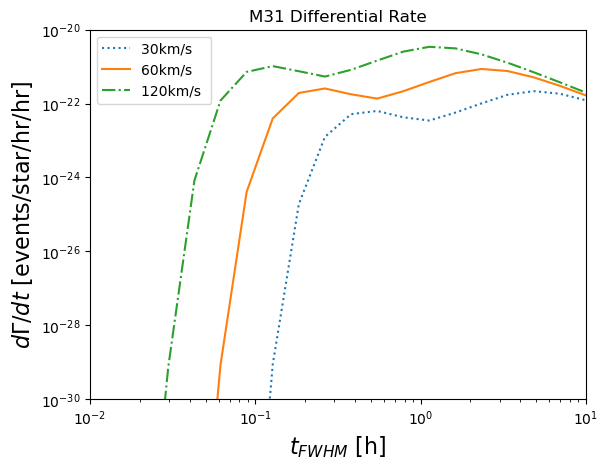

In [192]:
plt.loglog(np.array(ts), np.array(diff_rates_finite_m31_30), label="30km/s ", linestyle=':')
plt.loglog(np.array(ts), np.array(diff_rates_finite_m31), label="60km/s ", linestyle='-')
plt.loglog(np.array(ts), np.array(diff_rates_finite_m31_120), label="120km/s ", linestyle='-.')

plt.xlabel(r"$t_{FWHM}$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.title('M31 Differential Rate')
plt.xlim(min(ts), max(ts))
plt.ylim(1e-30,1e-20)
plt.legend()
plt.show()

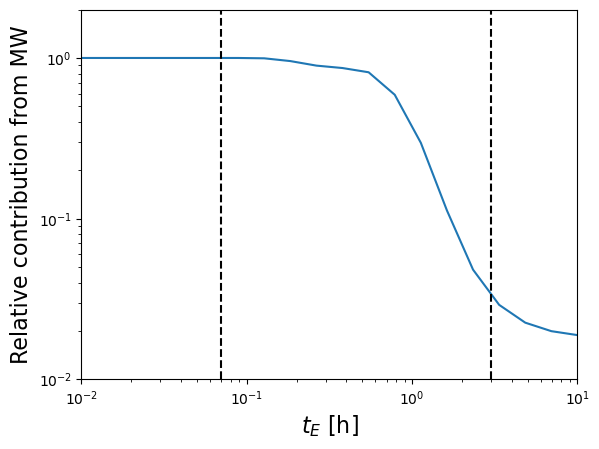

In [193]:
plt.loglog(np.array(ts), np.array(diff_rates_finite_mw)/(np.array(diff_rates_finite_mw) + np.array(diff_rates_finite_m31)))
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel("Relative contribution from MW", fontsize=16)
plt.xlim(min(ts), max(ts))
plt.ylim(1e-2,2)
plt.xlim(1e-2,1e1)

plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')

plt.show()

In [194]:
interp_mw = interp1d(ts,diff_rates_finite_mw)
interp_m31 = interp1d(ts,diff_rates_finite_m31)

In [195]:
interp_mw = interp1d(ts,diff_rates_finite_mw)
interp_m31 = interp1d(ts,diff_rates_finite_m31)

print(quad(lambda t: interp_mw(t), 0.07, 3)[0]/(quad(lambda t: interp_m31(t), 0.07, 3)[0] + quad(lambda t: interp_mw(t), 0.07, 3)[0]))


0.5713535152735556


In [ ]:
plt.loglog(np.array(ts), np.array(diff_rates_finite_mw), label="MW")
plt.loglog(np.array(ts), np.array(diff_rates_finite_m31), label="M31")
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)

plt.xlim(min(ts), max(ts))
plt.xlim(1e-2,1e1)
plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')

plt.ylim(1e-30,1e-19)
plt.legend()
plt.show()

In [15]:
m = 5e-14
ti = 0.07
tf = 3

f = Ffp(1, l=l, b=b)
ts = np.logspace(-2, np.log10(tf), num=10)

diff_rates_monochromatic_m31 = []
diff_rates_monochromatic_mw = []
for t in ts:
    diff_rates_monochromatic_m31.append(f.differential_rate_m31_monochromatic(t, finite=True, m=m))
    diff_rates_monochromatic_mw.append(f.differential_rate_mw_monochromatic(t, finite=True, m=m))

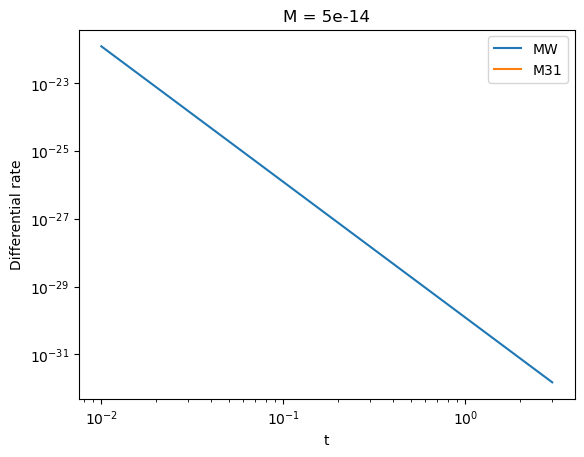

In [16]:
plt.loglog(ts,diff_rates_monochromatic_mw, label='MW')
plt.loglog(ts,diff_rates_monochromatic_m31, label='M31')
plt.xlabel('t')
plt.ylabel('Differential rate')
plt.title(f"M = {m}")
plt.legend()
plt.show()

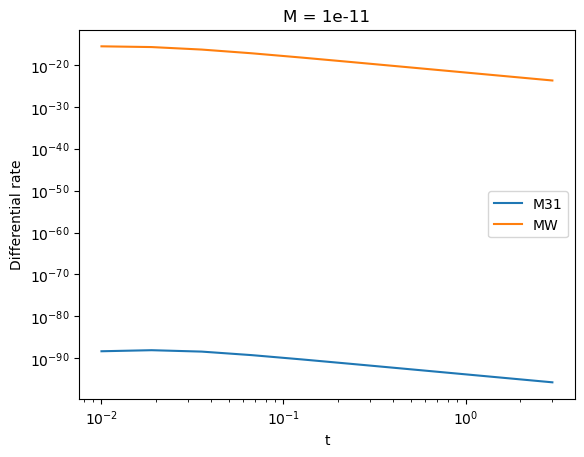

In [30]:
plt.loglog(ts,diff_rates_monochromatic_mw, label='MW')
plt.loglog(ts,diff_rates_monochromatic_m31, label='M31')
plt.xlabel('t')
plt.ylabel('Differential rate')
plt.title(f"M = {m}")
plt.legend()
plt.show()

In [26]:
def monochromatic_rate_ffp(m, return_sep=True):
    ti = 0.07
    tf = 3

    f = Ffp(1, l=l, b=b)
    ts = np.logspace(-2, np.log10(tf), num=10)

    diff_rates_monochromatic_m31 = []
    diff_rates_monochromatic_mw = []
    for t in ts:
        diff_rates_monochromatic_m31.append(f.differential_rate_m31_monochromatic(t, finite=True, m=m))
        diff_rates_monochromatic_mw.append(f.differential_rate_mw_monochromatic(t, finite=True, m=m))
    
    diff_interp_m31 = interp1d(ts, diff_rates_monochromatic_m31)
    diff_interp_mw = interp1d(ts, diff_rates_monochromatic_mw)

    quad_m31 = quad(diff_interp_m31, ti, tf)[0]
    quad_mw = quad(diff_interp_mw, ti, tf)[0]

    if return_sep:
        return quad_mw, quad_m31
    
    return quad_mw + quad_m31

def monochromatic_rate_ffp_point(m, return_sep=True):
    ti = 0.07
    tf = 3

    f = Ffp(1, l=l, b=b)
    ts = np.logspace(-2, np.log10(tf), num=10)

    diff_rates_monochromatic_m31 = []
    diff_rates_monochromatic_mw = []
    for t in ts:
        diff_rates_monochromatic_m31.append(f.differential_rate_m31_monochromatic(t, finite=False, m=m))
        diff_rates_monochromatic_mw.append(f.differential_rate_mw_monochromatic(t, finite=False, m=m))
    
    diff_interp_m31 = interp1d(ts, diff_rates_monochromatic_m31)
    diff_interp_mw = interp1d(ts, diff_rates_monochromatic_mw)

    quad_m31 = quad(diff_interp_m31, ti, tf)[0]
    quad_mw = quad(diff_interp_mw, ti, tf)[0]

    if return_sep:
        return quad_mw, quad_m31
    
    return quad_mw + quad_m31

In [7]:
# m_arr = np.logspace(-10, -4, 20) #solar masses
m_arr = np.logspace(-14, -4, 16) #solar masses
# m_arr = np.logspace(-12, -11, 32) #solar masses

p = 1
M_EARTH = 3e-6 # Earth mass in solar masses

with Pool() as pool:
    rates  = list(tqdm(pool.imap(monochromatic_rate_ffp, m_arr), total=len(m_arr)))

rates_mw = []
rates_m31 = []
for rate in rates:
    rates_mw.append(rate[0])
    rates_m31.append(rate[1])
    
rates_mw = np.array(rates_mw)
rates_m31 = np.array(rates_m31)

  6%|▋         | 1/16 [00:00<00:05,  2.61it/s]/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/pytho

In [28]:
with Pool() as pool:
    rates_point  = list(tqdm(pool.imap(monochromatic_rate_ffp_point, m_arr), total=len(m_arr)))

rates_mw_point = []
rates_m31_point = []
for rate in rates_point:
    rates_mw_point.append(rate[0])
    rates_m31_point.append(rate[1])
    
rates_mw_point = np.array(rates_mw_point)
rates_m31_point = np.array(rates_m31_point)

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:03<00:00,  4.04it/s]


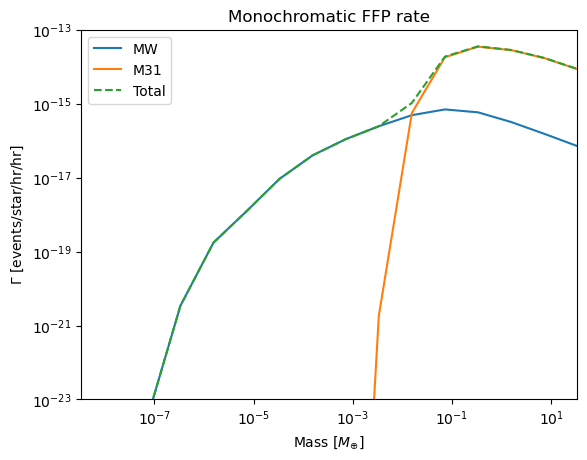

In [8]:
plt.plot(m_arr/M_EARTH, rates_mw, label="MW")
plt.plot(m_arr/M_EARTH, rates_m31, label="M31")
plt.plot(m_arr/M_EARTH, rates_mw + rates_m31, label="Total", ls = "--")

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Mass [$M_{\oplus}$]')
plt.ylabel(r"$\Gamma$ [events/star/hr/hr]")

plt.title("Monochromatic FFP rate")

plt.legend()

# plt.xlim(min(m_arr), max(m_arr))
plt.xlim(np.min(m_arr)/M_EARTH, np.max(m_arr)/M_EARTH)

plt.ylim(1e-23, 1e-13)
# plt.ylim(2e-17, 1e-13)

plt.show()


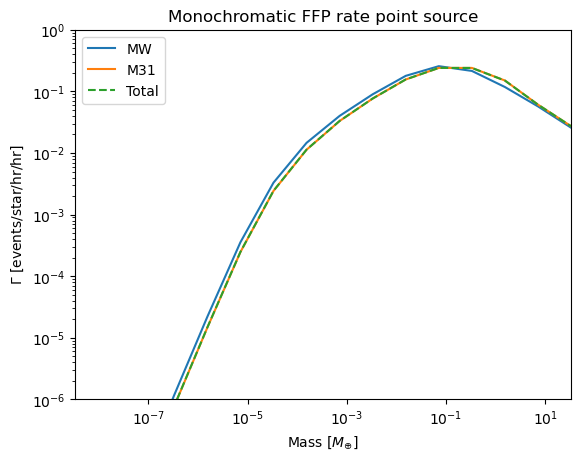

In [125]:
plt.plot(m_arr/M_EARTH, rates_mw_point/np.sum(rates_mw_point), label="MW")
plt.plot(m_arr/M_EARTH, rates_m31_point/np.sum(rates_m31_point), label="M31")
plt.plot(m_arr/M_EARTH, (rates_mw_point + rates_m31_point) / np.sum(rates_mw_point + rates_m31_point), label="Total", ls = "--")

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Mass [$M_{\oplus}$]')
plt.ylabel(r"$\Gamma$ [events/star/hr/hr]")

plt.title("Monochromatic FFP rate point source")

plt.legend()

# plt.xlim(min(m_arr), max(m_arr))
plt.xlim(np.min(m_arr)/M_EARTH, np.max(m_arr)/M_EARTH)

# plt.ylim(1e-23, 1e-13)
plt.ylim(1e-6, 1)
plt.show()


In [136]:
# mass_func_weights = (m_arr**-2)/np.sum(m_arr**-2)
mass_func_weights = (m_arr**-2) * np.diff(np.append([0],m_arr))

In [137]:
mass_func_weights

array([1.00000000e+14, 1.69027581e+13, 3.64158883e+12, 7.84556531e+11,
       1.69027581e+11, 3.64158883e+10, 7.84556531e+09, 1.69027581e+09,
       3.64158883e+08, 7.84556531e+07, 1.69027581e+07, 3.64158883e+06,
       7.84556531e+05, 1.69027581e+05, 3.64158883e+04, 7.84556531e+03])

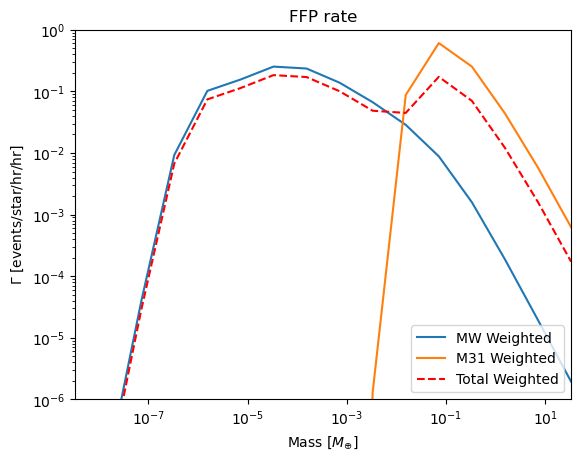

In [121]:
plt.plot(m_arr/M_EARTH, rates_mw*mass_func_weights/np.sum(rates_mw * mass_func_weights), label="MW Weighted")
plt.plot(m_arr/M_EARTH, rates_m31*mass_func_weights/np.sum(rates_m31 * mass_func_weights), label="M31 Weighted")
plt.plot(m_arr/M_EARTH, (rates_mw + rates_m31)*mass_func_weights/np.sum((rates_mw + rates_m31) * mass_func_weights), label="Total Weighted", ls = "--", color='r')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Mass [$M_{\oplus}$]')
plt.ylabel(r"$\Gamma$ [events/star/hr/hr]")

plt.title("FFP rate")

plt.legend()

# plt.xlim(min(m_arr), max(m_arr))
# plt.xlim(np.min(m_arr)/M_EARTH, 3e1)
plt.xlim(np.min(m_arr)/M_EARTH, np.max(m_arr)/M_EARTH)

# plt.ylim(1e-30, 1e-20)
plt.ylim(1e-6, 1)

plt.show()


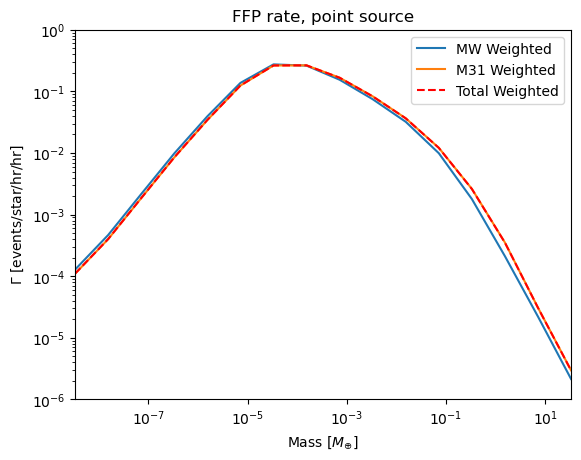

In [122]:
plt.plot(m_arr/M_EARTH, rates_mw_point*mass_func_weights / np.sum(rates_mw_point*mass_func_weights), label="MW Weighted")
plt.plot(m_arr/M_EARTH, rates_m31_point*mass_func_weights / np.sum(rates_m31_point*mass_func_weights), label="M31 Weighted")
plt.plot(m_arr/M_EARTH, (rates_mw_point + rates_m31_point)*mass_func_weights / np.sum((rates_mw_point + rates_m31_point)*mass_func_weights ), label="Total Weighted", ls = "--", color='r')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Mass [$M_{\oplus}$]')
plt.ylabel(r"$\Gamma$ [events/star/hr/hr]")

plt.title("FFP rate, point source")

plt.legend()

# plt.xlim(min(m_arr), max(m_arr))
# plt.xlim(np.min(m_arr)/M_EARTH, 3e1)
plt.xlim(np.min(m_arr)/M_EARTH, np.max(m_arr)/M_EARTH)

# plt.ylim(1e-30, 1e-21)
plt.ylim(1e-6, 1)
plt.show()

In [866]:
monochromatic_rate_ffp(2e-12, return_sep=False)

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


4.605769268787221e-21

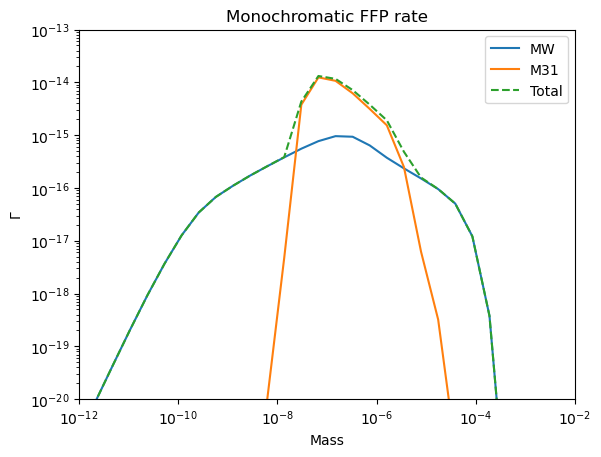

In [102]:
plt.plot(m_arr, rates_mw, label="MW")
plt.plot(m_arr, rates_m31, label="M31")
plt.plot(m_arr, rates_mw + rates_m31, label="Total", ls = "--")

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Mass")
plt.ylabel(r"$\Gamma$")
plt.title("Monochromatic FFP rate")

plt.legend()

plt.xlim(min(m_arr), max(m_arr))
plt.ylim(1e-20, 1e-13)
plt.show()

#Left hand side cutoff of M31 is due to finite size effects. Why is right hand side cutoff sharp relative to MW?

In [35]:
#Test that the mass function is normalized correctly
test_close(abs(nquad(f.mass_func,[[np.log10(f.m_min), np.log10(f.m_max)]], opts={'points': [f.m_min, f.m_min*1e3, f.m_min*1e5]})[0]), 1, eps=1e-3)

In [67]:
f = Ffp(0.5, l=l, b=b)

In [68]:
#Test that the mass function is normalized correctly
test_close(abs(nquad(f.f_m,[[f.m_min, f.m_max]], opts={'points': [f.m_min, f.m_min*1e3, f.m_min*1e6, f.m_max]})[0]), 1, eps=1e-3)

### Ensure limits are independent of mass function start/end

In [99]:
#! Check this calculation after updates to FFP class
def get_n_events(A, alpha=2, finite=False, m_min=1e-15):
    #Now A is number of FFPs per star
    f = Ffp(alpha, m_min=m_min)
    ti = 0.07
    tf = 3
    t_es = np.logspace(-2, 1, num=20)
    diff_rates = f.compute_differential_rate(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return n_sources*efficiency*dnds*obsTime*A

def get_constraint_iso(m_iso, alpha=2, finite=False, m_min=1e-15):
    f = Ffp(alpha, m_min=m_min)

    if m_iso < f.m_min:
        raise ValueError('Mass must be greater than the minimum mass of the FFP mass function')
    
    n_events = get_n_events(1, alpha=alpha, finite=finite, m_min=m_min)

    #Porportion of ISOs above threshold
    proportion_above_threshold = nquad(f.mass_func,[[m_iso, f.m_max]], opts={'points': [f.m_min, f.m_min*1e3, f.m_min*1e5]})[0]*f.Z

    #Maximum number of total allowed ISOs per star
    N_thresh = 4.74/n_events

    #Maximum number of allowed ISOs per star of mass m_iso or above
    return N_thresh * proportion_above_threshold    

In [ ]:
m_mins = np.logspace(-15, -7, num=24)

def get_constraint_iso_wrapped(m_min):
    return get_constraint_iso(1e-7, alpha=2, finite=True, m_min=m_min)

with Pool() as p:
   isos_per_star_arr = list(tqdm(p.imap(get_constraint_iso_wrapped, m_mins), total=len(m_mins)))

100%|██████████| 20/20 [06:52<00:00, 20.64s/it]


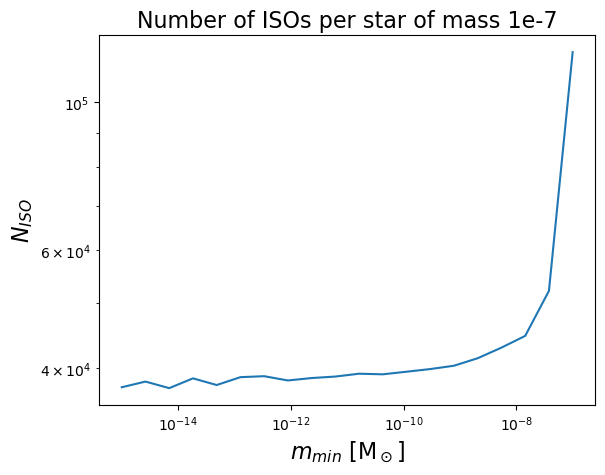

In [ ]:
# Expect to see that results are independent of m_min until the cutoff is in the range that HSC is sensitive to
# Looks good!
plt.plot(m_mins, isos_per_star_arr)
plt.xscale('log')
plt.yscale('log')
# plt.ylim(1e7, 1e8)
plt.xlabel(r"$m_{min}$ [M$_\odot$]", fontsize=16)
plt.ylabel(r"$N_{ISO}$", fontsize=16)
plt.title('Number of ISOs per star of mass 1e-7', fontsize=16)
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()